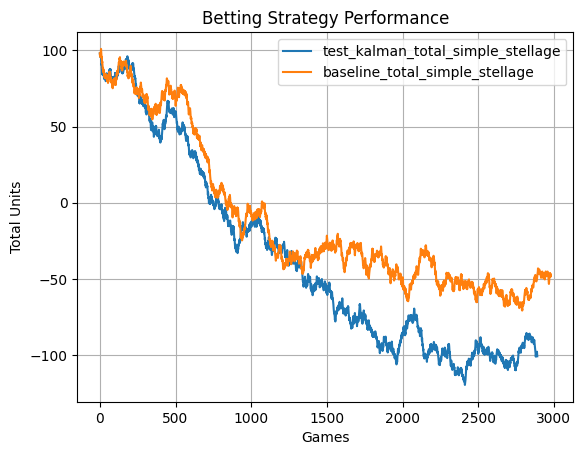

,Mean Average Error,Mean Squared Error,R-Squared,Sharpe,Net PNL,Max Drawdown,Number of Bets,Winning Bet %
model,,,,,,,,
test_kalman_total_simple_stellage,13.720678,296.503699,0.043076,-0.572110,-200.72,-219.51,2891,0.505016
baseline_total_simple_stellage,13.747981,297.584246,0.039589,-0.233554,-147.67,-170.64,2980,0.514765


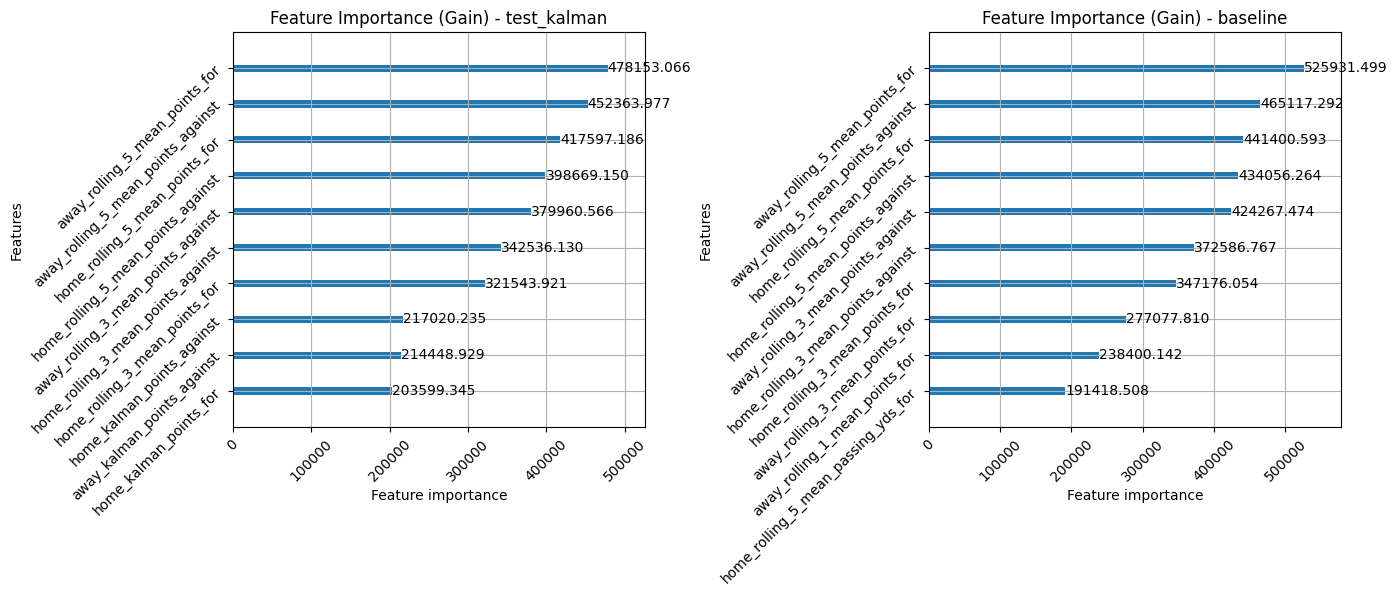

In [12]:
from evaluation import compare_models, load_pkl_if_exists
import strategy.betting_logic as betting_logic
import pandas as pd
compare_models("test_kalman", "baseline", betting_fncs=(betting_logic.simple_stellage, betting_logic.simple_stellage))

In [17]:
# Debug 
1/0

ZeroDivisionError: division by zero

In [13]:
load_pkl_if_exists("test_kalman",  file_type="contrib_df").columns

Index(['away_classification_iii', 'away_classification_None', 'attendance',
       'home_pregame_elo', 'away_pregame_elo', 'grass', 'season', 'week',
       'conference_game', 'home_days_since_last_game',
       ...
       'home_classification_iii', 'home_classification_None',
       'away_classification_fbs', 'away_classification_ii',
       'season_type_postseason', 'season_type_regular',
       'season_type_spring_postseason', 'season_type_spring_regular', 'dome',
       'neutral_site'],
      dtype='object', length=102)

In [ ]:
load_pkl_if_exists("test", file_type="contrib_df")
# Add num featurse

,attendance,home_pregame_elo,away_pregame_elo,season,week,home_days_since_last_game,away_days_since_last_game,home_rolling_5_mean_points_for,away_rolling_5_mean_points_for,home_rolling_3_mean_third_down_attempts,...,neutral_site,conference_game,away_rolling_3_mean_fourth_down_attempts,home_rolling_3_mean_fourth_down_successes,away_rolling_3_mean_fourth_down_successes,home_rolling_3_mean_ints_thrown,away_rolling_3_mean_ints_thrown,away_classification_fcs,home_classification_ii,home_classification_iii
id,,,,,,,,,,,,,,,,,,,,,
401012246,0.547458,4.130897,-0.157551,-2.615355,0.422559,-1.268034,0.616054,-3.353286,0.608357,0.248681,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
401012247,-1.881014,-0.066953,-0.063640,-2.353379,0.224375,-1.079228,-0.575188,-3.269870,0.579691,0.233025,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
401012248,-1.719673,0.742088,1.628790,-2.377628,0.496074,-1.172547,-0.636476,-3.321806,1.353649,0.257728,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
401012249,-3.831275,0.061243,0.035842,-2.371662,0.221449,-1.068045,-0.383274,-3.245637,0.416629,0.238571,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
401012250,0.725147,3.216339,0.201235,-3.074926,0.597978,-1.043447,-0.417281,-3.338833,0.656842,0.239564,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401737154,-0.125886,-0.096189,0.177668,NaN,0.024355,0.093016,0.046307,5.412336,-0.769763,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
401738295,-0.076300,-0.046888,0.185694,NaN,-0.220597,0.113227,0.093378,1.230757,-0.239268,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
401738307,-0.050291,0.051936,0.178873,NaN,-0.450675,-0.099884,0.092184,5.759024,5.703274,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Maybe like a plot percentage of offense vs. defense vs. etc. contributions?
cd = load_pkl_if_exists("test", file_type="contrib_df")
od = load_pkl_if_exists("test", betting_fnc=betting_logic.simple_stellage, file_type="odds_df")
tot = pd.merge(cd, od, on="id")

In [21]:
# vegas_rmse
od["vegas_pred"] = od[["min_ou", "max_ou"]].mean(axis=1, skipna=True)
od["mean_pred"] = od["total"].mean()

In [22]:
od

,total,min_ou,max_ou,pred,unit_pnl,vegas_pred,mean_pred
id,,,,,,,
332412309,27.0,NaN,NaN,None,0.00,NaN,54.41097
332412579,37.0,56.0,56.0,None,0.00,56.00,54.41097
332410154,38.0,NaN,NaN,None,0.00,NaN,54.41097
332412710,51.0,NaN,NaN,None,0.00,NaN,54.41097
332410084,108.0,NaN,NaN,None,0.00,NaN,54.41097
...,...,...,...,...,...,...,...
401741208,66.0,NaN,NaN,58.196915,0.00,NaN,54.41097
401680057,67.0,58.5,58.5,54.623904,0.00,58.50,54.41097
401677189,51.0,45.5,46.0,54.010421,0.87,45.75,54.41097


In [23]:
from sklearn.metrics import mean_absolute_error
od2 = od.dropna()
mean_absolute_error(od2["total"], od2["vegas_pred"])

np.float64(12.78955675391293)

In [24]:
mean_absolute_error(od2["total"], od2["mean_pred"])

np.float64(13.947841592163567)

In [26]:
from data.data_prep import DataPrep
from pipelines.preprocessing import get_preprocess_pipeline
data_prep = DataPrep(dataset="cfb")
raw_data = data_prep.get_data()

print("Step 2: Preprocess and separate odds, X, and y...")
preprocessed_data = get_preprocess_pipeline().fit_transform(raw_data)
target_col = "total"
betting_cols = ["min_ou", "max_ou"]

odds_df = preprocessed_data[[target_col] + betting_cols]
odds_df.loc[:, "pred"] = None
X = preprocessed_data.drop(columns=[target_col] + betting_cols)
y = preprocessed_data[target_col]

Step 2: Preprocess and separate odds, X, and y...


C:\Users\brtnl\AppData\Local\Temp\ipykernel_13324\3966701630.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  odds_df.loc[:, "pred"] = None


In [27]:
from pipelines.pipeline import get_features_and_model_pipeline
pipeline = get_features_and_model_pipeline()

In [30]:
pipeline.fit(X, y)

c:\Users\brtnl\OneDrive\Desktop\code\sports_betting\src\cfb\pipelines\features.py:51: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_[f"previous_game_{side}"].fillna(dt.date(2000, 1, 1), inplace=True)
c:\Users\brtnl\OneDrive\Desktop\code\sports_betting\src\cfb\pipelines\features.py:51: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on whi

Pipeline(steps=[('features',
                 Pipeline(steps=[('days_since', DaysSinceLastGameTransformer()),
                                 ('offense_pipeline',
                                  Pipeline(steps=[('rolling_offense_5',
                                                   RollingTransformer(away_col='away_points',
                                                                      home_col='home_points',
                                                                      new_col='points_for',
                                                                      window_size=5)),
                                                  ('rolling_third_down_attempts_3',
                                                   RollingTransformer(away_col='away_third_down_attempts',
                                                                      home_col='hom...
                                                   'elevation', 'capacity',
                                                   'team_away', 'previous_game',
                                                   'home_points', 'away_points',
                                                   'home_q1', 'home_q2',
                                                   'home_q3', 'home_q4',
                                                   'home_h1', 'home_h2',
                                                   'home_ot', 'away_q1',
                                                   'away_q2', ...])],
                                   verbose_feature_names_out=False)),
                ('variance_threshold', VarianceThreshold()),
                ('select_features', SelectKBest(k=20)),
                ('light_gbm',
                 LGBMRegressor(reg_alpha=0.5, reg_lambda=0.5, verbose=-1))])

In [32]:
s = pipeline.predict(X, pred_contrib=True)

c:\Users\brtnl\OneDrive\Desktop\code\sports_betting\src\cfb\pipelines\features.py:51: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_[f"previous_game_{side}"].fillna(dt.date(2000, 1, 1), inplace=True)
c:\Users\brtnl\OneDrive\Desktop\code\sports_betting\src\cfb\pipelines\features.py:51: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on whi

In [47]:
feature_names = pipeline.named_steps["light_gbm"].feature_name_ + ["bias"]

In [48]:
pd.DataFrame(s[:, :], columns=feature_names, index=X.index)

,home_classification_fbs,away_classification_fbs,season_type_regular,season_type_spring_regular,season,home_rolling_5_mean_points_for,away_rolling_5_mean_points_for,home_rolling_3_mean_third_down_attempts,away_rolling_3_mean_third_down_attempts,home_rolling_3_mean_third_down_successes,...,home_rolling_3_mean_fourth_down_attempts,home_rolling_3_mean_passing_yds_for,away_rolling_3_mean_passing_yds_for,home_rolling_3_mean_rushing_yds_for,away_rolling_3_mean_rushing_yds_for,home_rolling_3_mean_points_against,away_rolling_3_mean_points_against,home_rolling_5_mean_points_against,away_rolling_5_mean_points_against,bias
id,,,,,,,,,,,,,,,,,,,,,
332412309,0.611752,-0.069856,-0.002326,0.014026,1.348684,-2.220482,0.196037,0.030234,0.304615,-0.018319,...,-0.049258,-0.442892,-0.286768,-0.073210,0.040566,-1.130014,0.211378,1.092412,1.487717,54.410555
332412579,0.611752,-0.069856,-0.002326,0.014026,1.348684,-2.220482,0.196037,0.030234,0.304615,-0.018319,...,-0.049258,-0.442892,-0.286768,-0.073210,0.040566,-1.130014,0.211378,1.092412,1.487717,54.410555
332410154,0.799335,0.282825,-0.002326,0.014026,1.346753,-2.204326,0.292465,0.027110,0.309353,-0.018319,...,-0.049429,-0.443120,-0.241653,-0.080953,0.042321,-1.135083,0.213529,1.098825,1.342294,54.410555
332412710,-0.214535,0.058579,-0.002326,0.012144,1.355070,-2.380319,0.171861,0.018349,0.076829,-0.019648,...,-0.071516,-0.443251,-0.218002,-0.088465,0.044097,-1.062216,0.192659,1.084429,1.584270,54.410555
332410084,0.799335,0.282825,-0.002326,0.014026,1.346753,-2.204326,0.292465,0.027110,0.309353,-0.018319,...,-0.049429,-0.443120,-0.241653,-0.080953,0.042321,-1.135083,0.213529,1.098825,1.342294,54.410555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401741208,-0.101041,0.035358,0.303735,0.042848,-0.189383,4.495259,1.128002,0.052088,0.071475,0.104857,...,-0.115258,-0.540424,-0.352053,-0.017051,0.139446,-2.725485,-0.137458,-4.353804,-2.687890,54.410555
401680057,-0.053729,0.024747,2.464892,0.065021,-0.104967,5.192778,2.788141,0.047822,-0.025853,0.329427,...,0.074573,-0.512454,0.334804,-0.348011,-0.537554,0.321236,-0.020256,-1.432348,-1.253691,54.410555
401677189,0.226695,-0.022779,0.758927,-0.014187,-0.286536,1.811440,1.941825,0.010618,-0.005931,0.154215,...,0.054549,-0.161108,-0.569192,-0.066002,0.015684,0.243777,-0.094366,-3.242786,-2.779673,54.410555


In [15]:
# Do not delete
test = load_pkl_if_exists("top10", betting_fnc=betting_logic.simple_stellage)
base = load_pkl_if_exists("baseline", betting_fnc=betting_logic.simple_stellage)

In [22]:
merge_df = pd.merge(test, base, on=["id", "total", "max_ou", "min_ou"], suffixes=["_pre","_post"])
questions = merge_df[merge_df["unit_pnl_post"] < merge_df["unit_pnl_pre"]]

In [23]:
questions

,total,min_ou,max_ou,pred_pre,unit_pnl_pre,pred_post,unit_pnl_post
id,,,,,,,
401013087,76.0,62.5,63.0,56.285574,0.00,56.183917,-1.00
401012274,58.0,59.0,60.0,51.911316,0.87,56.183917,0.00
401012278,66.0,62.5,63.5,56.285574,0.00,56.183917,-1.00
401019490,92.0,74.5,75.0,64.2567,-1.00,56.183917,-2.00
401012875,55.0,46.5,47.0,56.957617,1.74,55.28014,0.87
...,...,...,...,...,...,...,...
401677190,69.0,49.5,50.5,58.232957,0.87,53.876418,0.00
401677103,38.0,49.5,50.0,51.186778,0.00,62.913434,-2.00
401677181,45.0,54.5,55.0,45.741329,0.87,50.762851,0.00


In [ ]:
offense_roots = ["points_for", "third_down_attempts","third_down_successes","fourth_down_attempts","fourth_down_successes","passing_yds_for","ints_thrown","rushing_yds_for","passing_tds","rushing_tds",]
defense_roots = ["points_against","passing_yds_given_up"]
"""
def_cols = df.columns.endwith(defense_roots)
df["def_contrib"] = sum(df[def_cols])
"""

In [1]:
from evaluation import get_group_features

In [4]:
s = get_group_features("test")

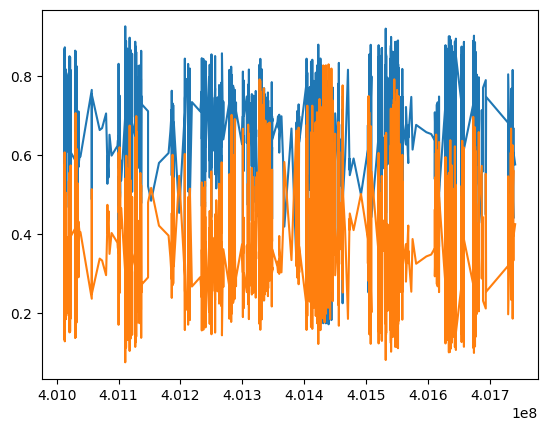

In [6]:
import matplotlib.pyplot as plt
plt.plot(s["offense_pct"])
plt.plot(s["defense_pct"])